In [11]:
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so

from sklearn import linear_model    # Herramientas de modelos lineales
from sklearn.metrics import mean_squared_error, r2_score    # Medidas de desempeño
from sklearn.preprocessing import PolynomialFeatures    # Herramientas de polinomios

from sklearn.model_selection import train_test_split, KFold, cross_val_score

from formulaic import Formula

# Interacciones entre variables

In [12]:
# Consideramos un ejemplo con variables sintéticas

df = pd.DataFrame({
    'y': [11, 10.5, 7.8, 9.6, 2.1, 4.3],
    'x1': ['Y', 'Y', 'N', 'N', 'Y', 'Y'],
    'x2': [0.3, 0.1, 0.2, 0.7, 0.6, 0.6],
    'x3': [100, 121, 17, 89, 45, 32],
    'x4': ['A', 'B', 'C', 'C', 'A', 'C'],
})
df

,y,x1,x2,x3,x4
0,11.0,Y,0.3,100,A
1,10.5,Y,0.1,121,B
2,7.8,N,0.2,17,C
3,9.6,N,0.7,89,C
4,2.1,Y,0.6,45,A
5,4.3,Y,0.6,32,C


In [13]:
# Queremos modelar y usando la interacción entre x2 y x3.
# Por ejemplo, x2 es el porcentaje de grasa de un alimento, x3 es el peso del alimento 
y, X = (
    Formula('y ~ x2 : x3')
    .get_model_matrix(df)
)
display(X.head()) 

,Intercept,x2:x3
0,1.0,30.0
1,1.0,12.1
2,1.0,3.4
3,1.0,62.3
4,1.0,27.0


In [14]:
# Para no abusar de formulaic... cómo podemos agregar la variable grasa_total a mano?
df['grasa_total']=df.x2*df.x3

In [15]:
# Si queremos conservar también las variables originales...
y, X = (
    Formula('y ~ x2 * x3')
    .get_model_matrix(df)
)
display(X) 

,Intercept,x2,x3,x2:x3
0,1.0,0.3,100,30.0
1,1.0,0.1,121,12.1
2,1.0,0.2,17,3.4
3,1.0,0.7,89,62.3
4,1.0,0.6,45,27.0
5,1.0,0.6,32,19.2


In [16]:
# Y si queremos el x3 y la interacción entre x2 y x3 pero no queremos x2?
y, X = (
    Formula('y ~ x2 * x3 - x2')
    .get_model_matrix(df)
)
display(X)

,Intercept,x3,x2:x3
0,1.0,100,30.0
1,1.0,121,12.1
2,1.0,17,3.4
3,1.0,89,62.3
4,1.0,45,27.0
5,1.0,32,19.2


In [19]:
y, X = (
    Formula('y ~ x1')
    .get_model_matrix(df)
)
display(X)

,Intercept,x1[T.Y]
0,1.0,1
1,1.0,1
2,1.0,0
3,1.0,0
4,1.0,1
5,1.0,1


In [17]:
# Queremos agregar ahora la interacción entre x1 y x2.
y, X = (
    Formula('y ~ x1 : x2')
    .get_model_matrix(df)
)
display(X)

# Explicar qué columnas nos creó formulaic. Porqué crea dos y no una sola?

,Intercept,x1[N]:x2,x1[Y]:x2
0,1.0,0.0,0.3
1,1.0,0.0,0.1
2,1.0,0.2,0.0
3,1.0,0.7,0.0
4,1.0,0.0,0.6
5,1.0,0.0,0.6


In [23]:
# Qué esperamos en este caso?
y, X = (
    Formula('y ~ x2 * x1')
    .get_model_matrix(df)
)
display(X)

,Intercept,x2,x1[T.Y],x2:x1[T.Y]
0,1.0,0.3,1,0.3
1,1.0,0.1,1,0.1
2,1.0,0.2,0,0.0
3,1.0,0.7,0,0.0
4,1.0,0.6,1,0.6
5,1.0,0.6,1,0.6


In [24]:
# Si queremos las dos variables como antes...
y, X = (
    Formula('y ~ x1 * x2 - x2')
    .get_model_matrix(df)
)
display(X)

,Intercept,x1[T.Y],x1[N]:x2,x1[Y]:x2
0,1.0,1,0.0,0.3
1,1.0,1,0.0,0.1
2,1.0,0,0.2,0.0
3,1.0,0,0.7,0.0
4,1.0,1,0.0,0.6
5,1.0,1,0.0,0.6


In [ ]:
# Observamos que sacamos una variable pero formulaic nos agrego otra!

In [25]:
# Agreguemos ahora la interacción entre x3 y x4
# Qué esperamos acá?

# Si queremos las dos variables como antes...
y, X = (
    Formula('y ~ x3 : x4')
    .get_model_matrix(df)
)
display(X)

,Intercept,x3:x4[A],x3:x4[B],x3:x4[C]
0,1.0,100,0,0
1,1.0,0,121,0
2,1.0,0,0,17
3,1.0,0,0,89
4,1.0,45,0,0
5,1.0,0,0,32


# Interacciones entre variables y la paradoja de Simpson.

Queremos estudiar la relación entre la longitud y la profundidad del pico de los pingüinos.

Vamos a utilizar
x = bill_length_mm,  y = bill_depth_mm

In [26]:
penguins = sns.load_dataset("penguins")
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [27]:
# Vemos que hay datos faltanes.
# Eliminamos las filas con datos faltantes y reseteamos indices (muy importante para graficar predicciones!)
penguins = penguins.dropna().reset_index()
penguins

,index,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
4,5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male
...,...,...,...,...,...,...,...,...
328,338,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,Female
329,340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
330,341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
331,342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


In [28]:
# Ajustamos un modelo lineal y calculamos el coeficiente de correlación R^2
y, X = (
    Formula('bill_depth_mm ~ bill_length_mm')
    .get_model_matrix(penguins)
)
display(X.head()) 

,Intercept,bill_length_mm
0,1.0,39.1
1,1.0,39.5
2,1.0,40.3
3,1.0,36.7
4,1.0,39.3


In [29]:
modelo = linear_model.LinearRegression(fit_intercept = False)    # Inicializamos un modelo de Regresion Lineal sin intercept
modelo.fit(X, y)   # Realizamos el ajuste
print("Coeficientes:", modelo.coef_)

y_pred = modelo.predict(X)
# Calculando el R^2
r2 = r2_score(y, y_pred)
print('R^2: ', r2)

# Calculando el ECM
ecm = mean_squared_error(y, y_pred)
print('Raiz cuadarada del ECM: ', np.sqrt(ecm))

Coeficientes: [[20.78664867 -0.08232675]]
R^2:  0.0522696813966369
Raiz cuadarada del ECM:  1.914198451038257


Si analizamos rápidamente estos resultados diríamos que no hay relación entre el largo y la produndidad... (o que hay correlación negativa porque la pendiente es negativa). Resulta un poco extraño...

¿Cómo podemos analizar mejor qué está pasando?

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.




Realicemos un gráfico!

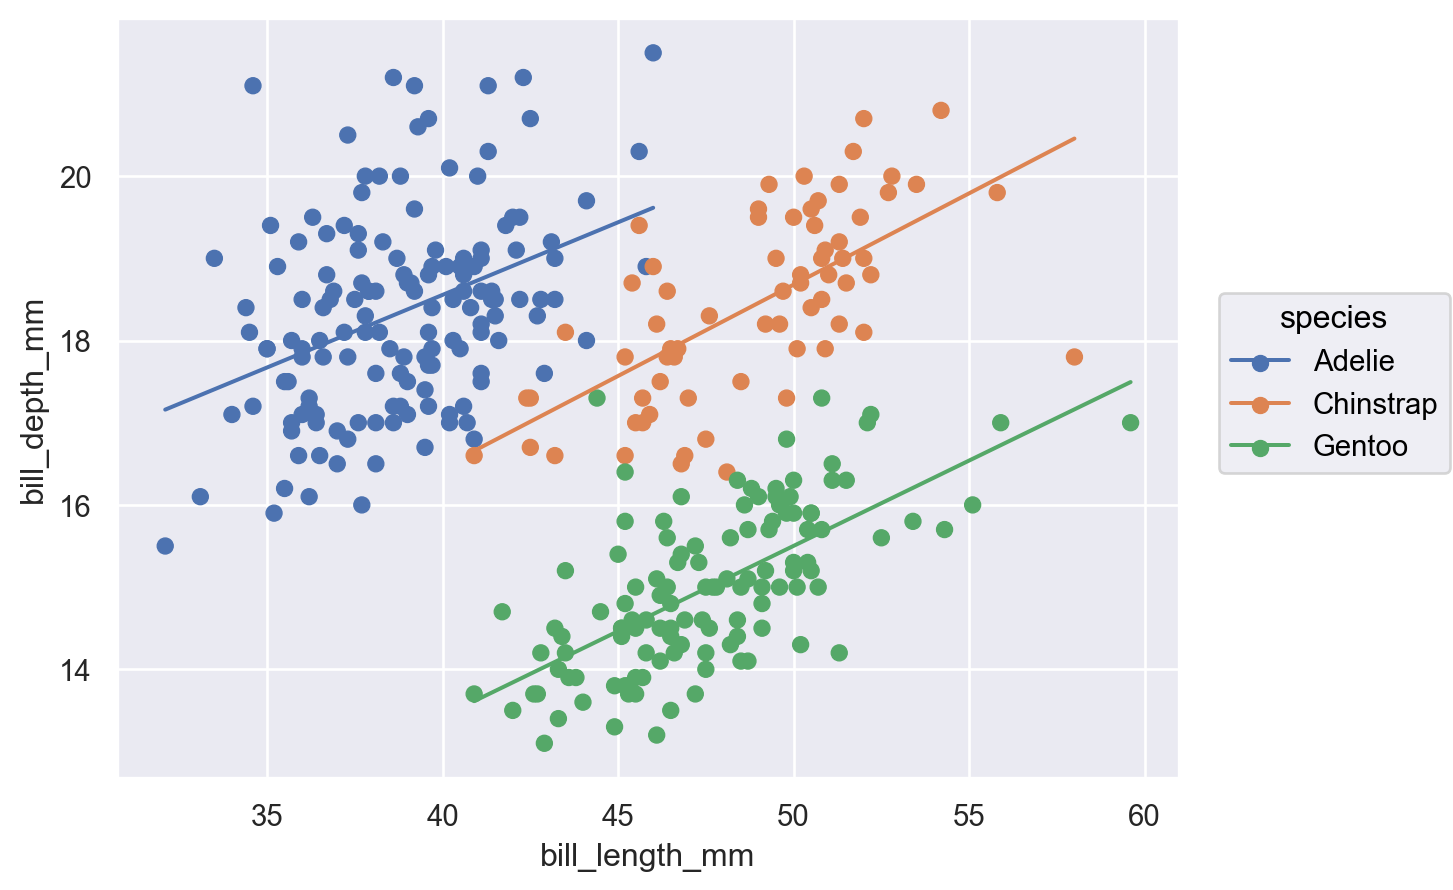

In [41]:
(
    so.Plot(data = penguins, x = "bill_length_mm", y = "bill_depth_mm", color='species')
    .add(so.Dot())
    .add(so.Line(), so.PolyFit(1))
)

El gráfico confirma la correlación negativa, pero notan algo raro? Tal vez hay algo que no estamos teniendo en cuenta?

.

.

.

.

.


.

.

.

.

.


.

.

.

.

.



Repetimos el gráfico coloreando los puntos según la especie.

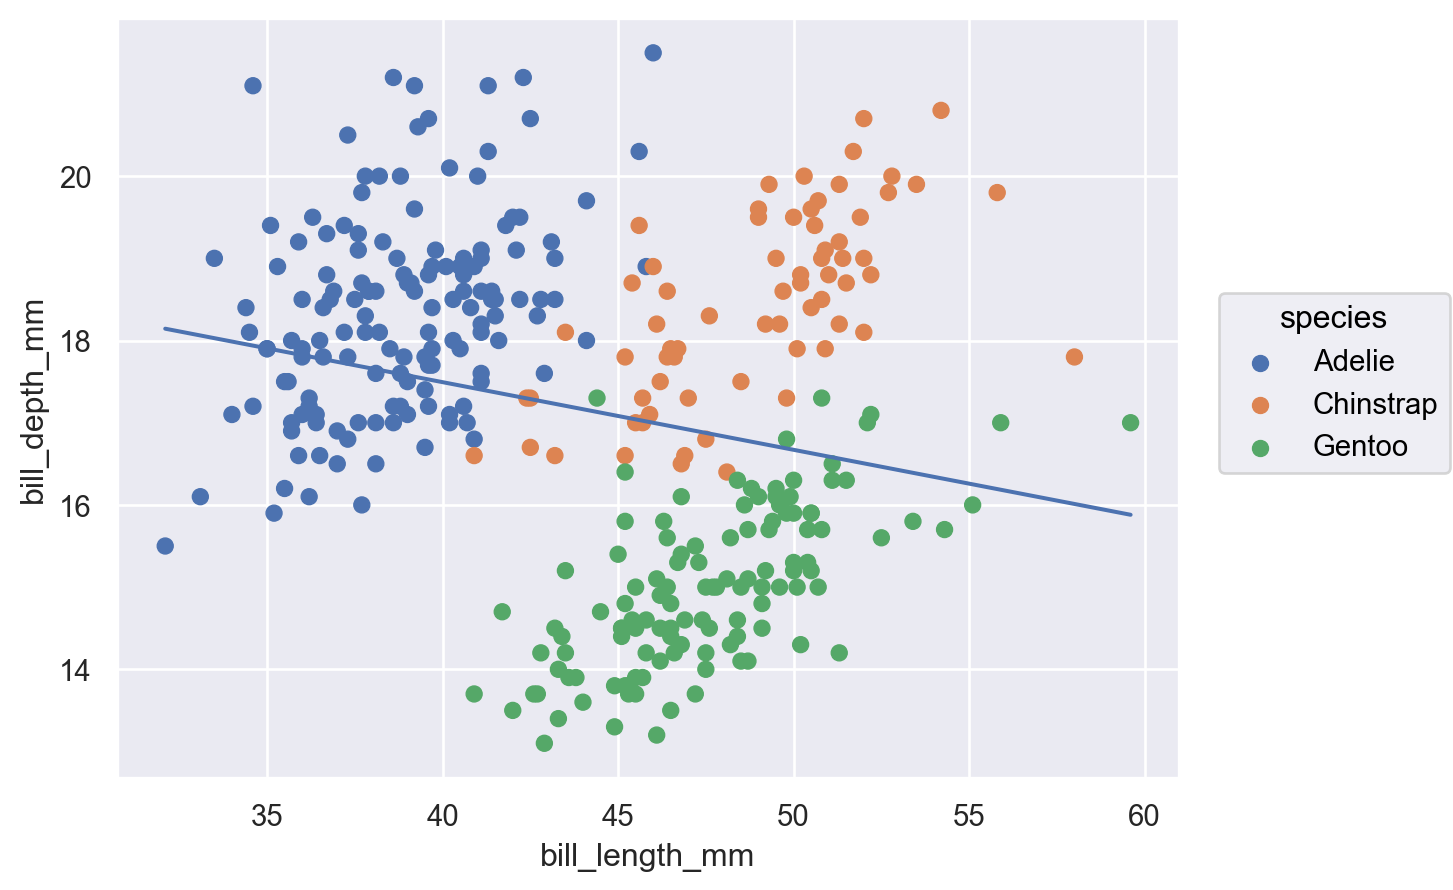

In [31]:
(
    so.Plot(data = penguins, x = "bill_length_mm", y = "bill_depth_mm")
    .add(so.Dot(), color = "species")
    .add(so.Line(), so.PolyFit(1))
)

En este gráfico por especie vemos dentro de cada especie puede haber correlación. Verificamos agregando los ajustes por especie.

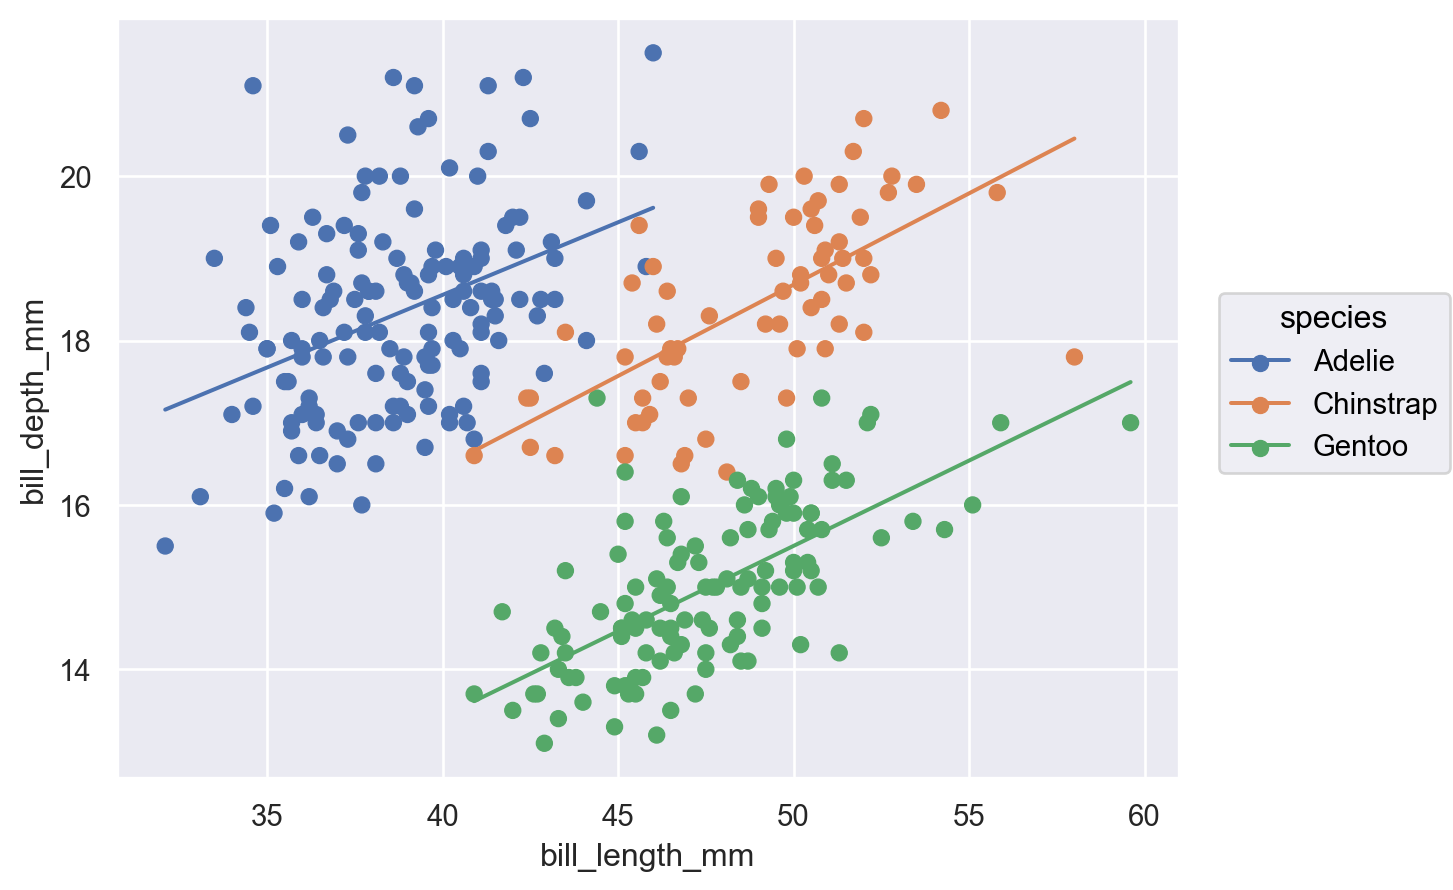

In [32]:
(
    so.Plot(data = penguins, x = "bill_length_mm", y = "bill_depth_mm", color = "species")
    .add(so.Dot())
    .add(so.Line(), so.PolyFit(1))
)

Ahora las rectas tienen pendiente positiva! Al considerar todas las especies al mismo tiempo, no podíamos ver esta correlación.

## La paradoja de Simpson
La paradoja de Simpson es un fenómeno estadístico en el cual una relación entre variables aparece, desaparece o se revierte al dividir a la población en subpoblaciones.

**Ejemplo.** Veamos otro ejemplo simulado.
Generamos dos poblaciones distribuidas aleatoriamente alrededor de dos centros.

In [54]:
from sklearn.datasets import make_blobs
centers = [[2, 2], [-2, -2]]
X, labels_true = make_blobs(
    n_samples=750, centers=centers, cluster_std=0.4, random_state=0)
x = X[:,0]
y = X[:,1]

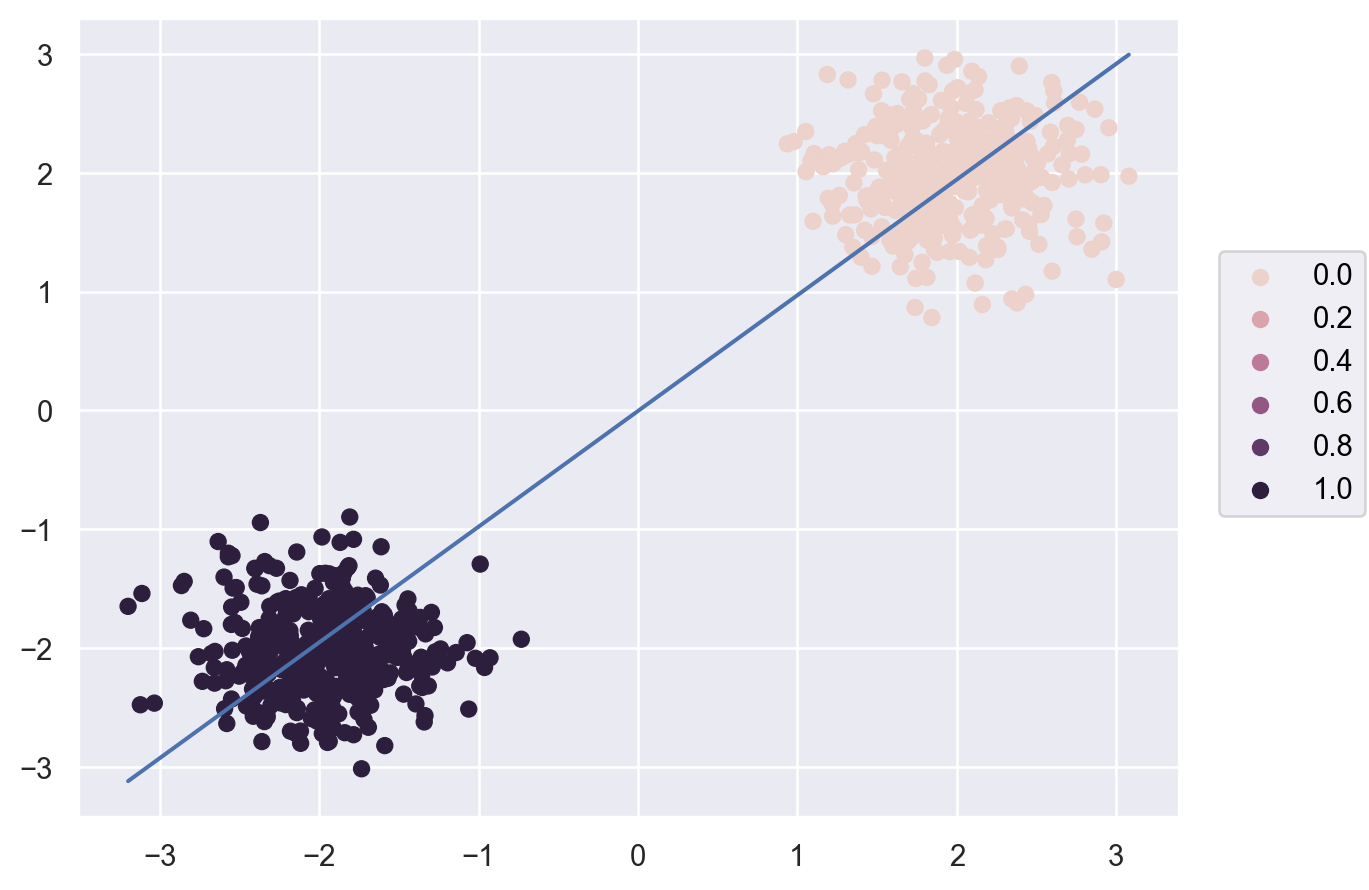

In [55]:
(
    so.Plot(x = x, y = y)
    .add(so.Dot(), color = labels_true)
    .add(so.Line(), so.PolyFit(1))
)

En este ejemplo, podríamos decir que hay correlación entre la variable $x$ y la variable $y$?

Calculemos el R^2...

In [56]:
modelo = linear_model.LinearRegression()    # Inicializamos un modelo de Regresion Lineal
modelo.fit(pd.DataFrame(x), y)   # Realiza

print("Coeficientes:", modelo.coef_)

# Medidas de bondad

y_pred = modelo.predict(pd.DataFrame(X[:,0]))

# Calculando el R^2
r2 = r2_score(X[:,1], y_pred)
print('R^2: ', r2)

Coeficientes: [0.97356812]
R^2:  0.9255602605070439


Los datos parecen altamente correlacionados. Pero si separamos por grupo...

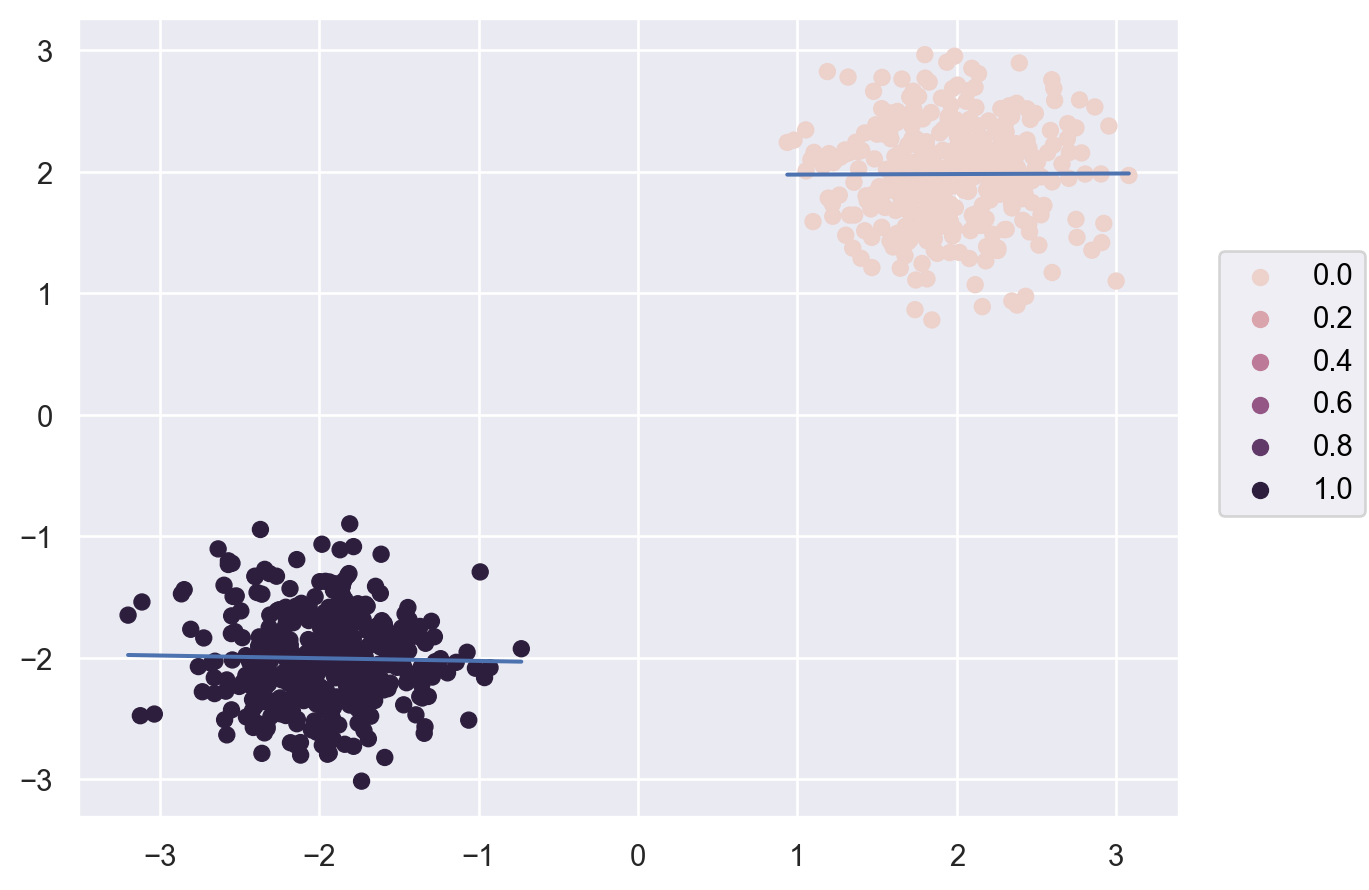

In [45]:
(
    so.Plot(x = x, y = y)
    .add(so.Dot(), color = labels_true)
    .add(so.Line(), so.PolyFit(1), group = labels_true)
)

Vemos en el gráfico que la pendiente ahora pasa a ser casi 0.

¿Cómo podemos construir nosotros estos modelos y calcular los coeficientes y el R^2?

Recordemos las operaciones que nos permite hacer Formulaic.

| Operador | Ejemplo          | Función                                                                                           |
|:---------|:-----------------|:---------------------------------------------------------------------------------------------------|
| ~        | y ~ x            | Separa la variable (y) respuesta a la izquierda, de el/los predictor/es a la derecha (x).       |
| +        | y ~ x + z        | Adiciona (suma) términos al modelo.                                                              |
| :        | y ~ x : z        | Interacción entre términos. y es lineal en x ⋅ z.                                                |
| *        | y ~ x * z        | Combina adición e interacción entre términos. y ~ x * z es equivalente a y ~ x + z + x : z       |

In [57]:
# Comenzamos con un modelo simple:
# agregamos la especie como una variable más del modelo.
y, X = Formula("bill_depth_mm ~ bill_length_mm + species").get_model_matrix(penguins)
X.head()

,Intercept,bill_length_mm,species[T.Chinstrap],species[T.Gentoo]
0,1.0,39.1,0,0
1,1.0,39.5,0,0
2,1.0,40.3,0,0
3,1.0,36.7,0,0
4,1.0,39.3,0,0


In [58]:
# Ajustamos el modelo 
modelo = linear_model.LinearRegression(fit_intercept = False)    # Inicializamos un modelo de Regresion Lineal sin intercept
modelo.fit(X, y)   # Realiza
print("Coeficientes:", modelo.coef_)

Coeficientes: [[10.56526162  0.20044313 -1.93307791 -5.10331533]]


In [59]:
# Graficamos este modelo

# Notemos que queremos graficar un modelo con DOS VARIABLES EXPLICATIVAS. 
# Si fueran dos variables explicativas numéricas necesitamos hacer un gráfico en 3 dimensiones y = f(x_1, x_2) (o z = f(x,y))
# Pero en nuestro caso, una variable es categórica, cómo podemos hacerlo en este caso?

# Para eso, agregamos al dataframe de pingüinos nuestras predicciones
# Agregamos la variable y_pred a los datos para poder graficar con seaborn
datos = penguins.copy()

y_pred = modelo.predict(X)
datos["predicciones"] = y_pred
datos.head()

,index,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,predicciones
0,0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male,18.402588
1,1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female,18.482765
2,2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female,18.643120
3,4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female,17.921525
4,5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male,18.442677


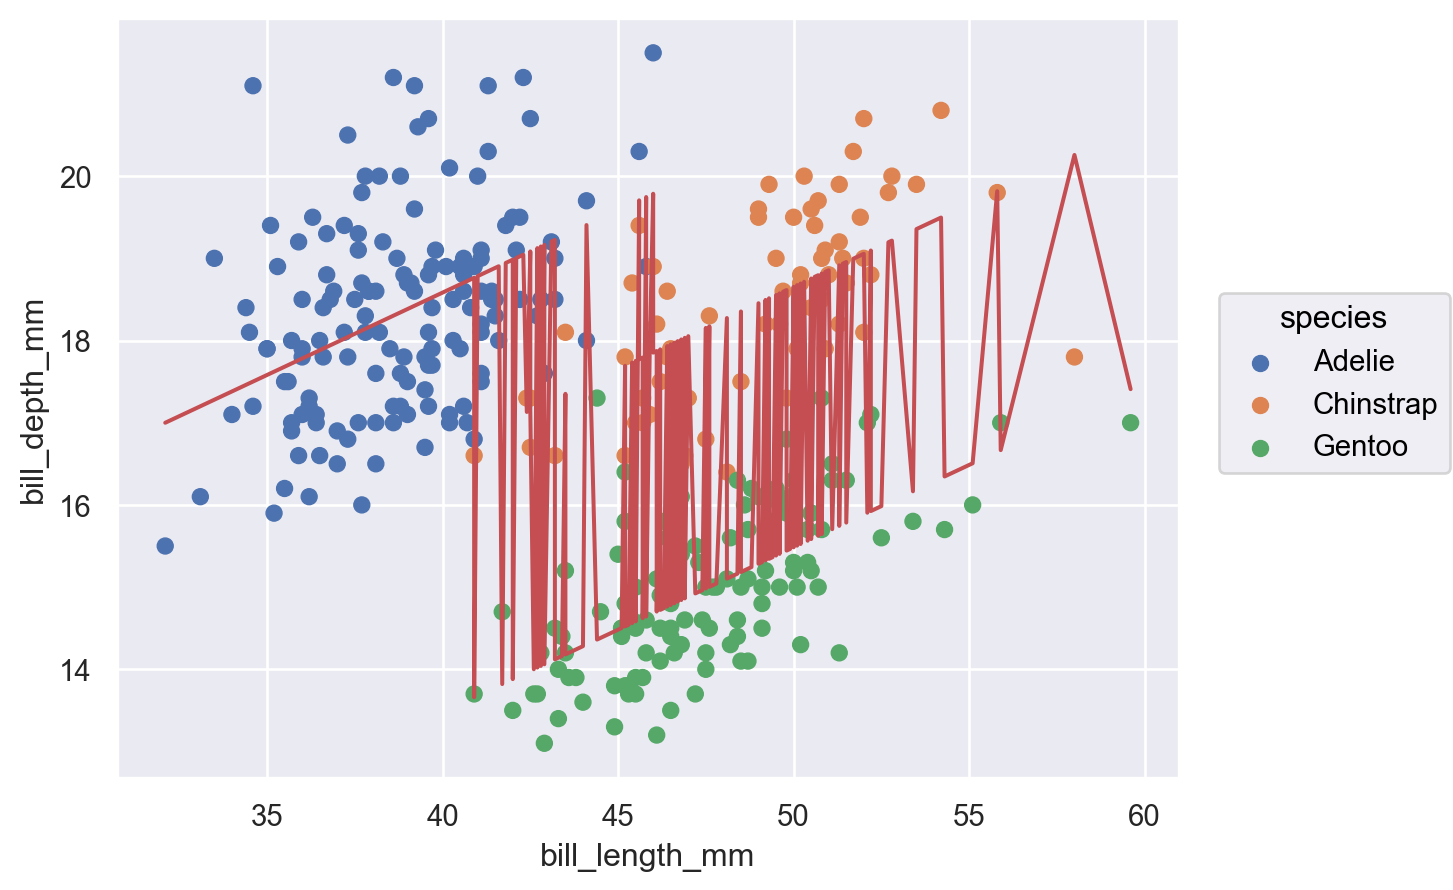

In [60]:
# Realizamos el gráfico agregando una marca de línea para el ajuste del modelo.
(
    so.Plot(data = datos, x = "bill_length_mm")
    .add(so.Dot(), y = "bill_depth_mm", color = "species")
    .add(so.Line(color = "r"), y = "predicciones") 
)


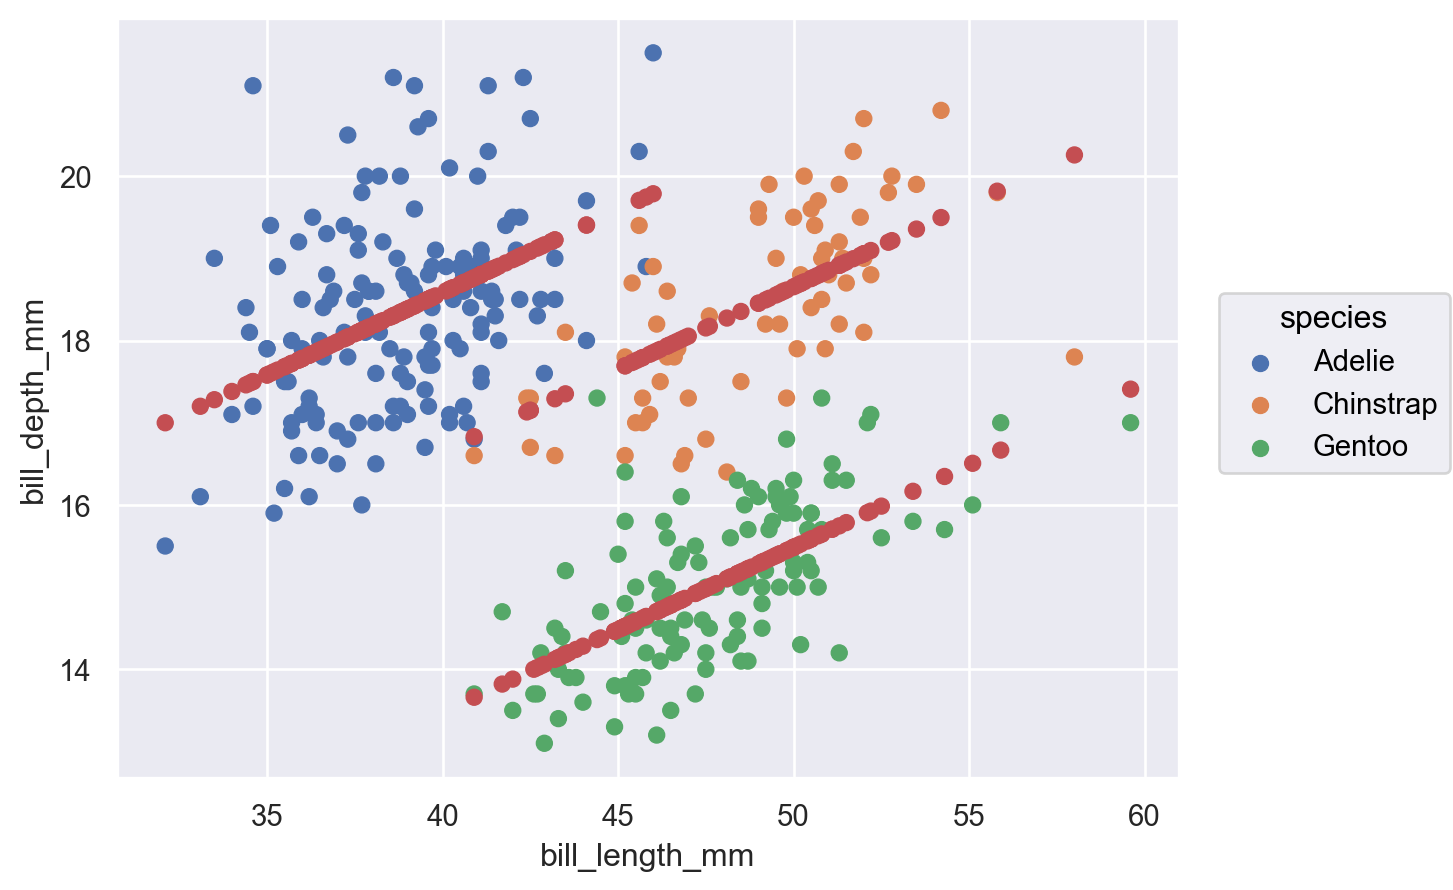

In [61]:
# No es lo que queriamos... El gráfico de lineas va saltando de una especie a otra.

# Para entender este gráfico, usemos puntos en vez de líneas

# Realizamos el gráfico agregando una marca de línea para el ajuste del modelo.
(
    so.Plot(data = datos, x = "bill_length_mm")
    .add(so.Dot(), y = "bill_depth_mm", color = "species")
    .add(so.Dot(color = "r"), y = "predicciones") 
)


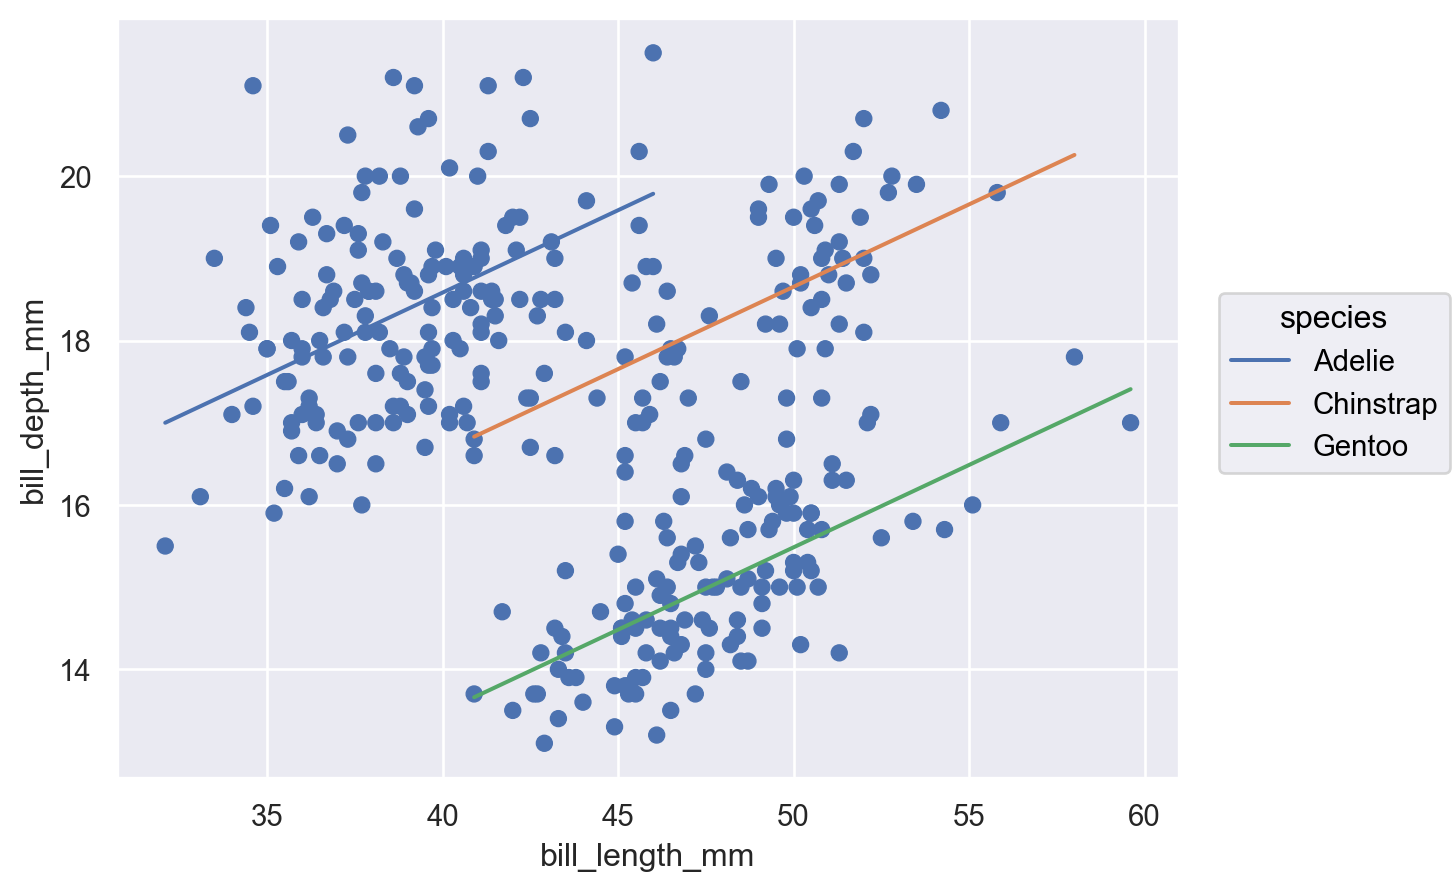

In [62]:
# Cómo podemos cambiar los puntos por líneas respetando lo que vemos en el último gráfico?
# Agrupamos el gráfico de líneas por especie! Ahora solo conecta por una línea las predicciones de una misma especie
(
    so.Plot(data = datos, x = "bill_length_mm")
    .add(so.Dot(), y = "bill_depth_mm")
    .add(so.Line(), y = "predicciones", color = "species") # Magia!
)

# No necesitamos agregar 3 líneas distintas, una para cada especie!

Notar que entre cada especie, su recta de regresion lineal simplemente cambia la ordenada al origen, pero no cambia la pendiente, esto es porque como las categoricas son 0 o 1, entonces suma o no su coeficiente corresondiente, lo cual afecta a la ordenada al origen nomas. 

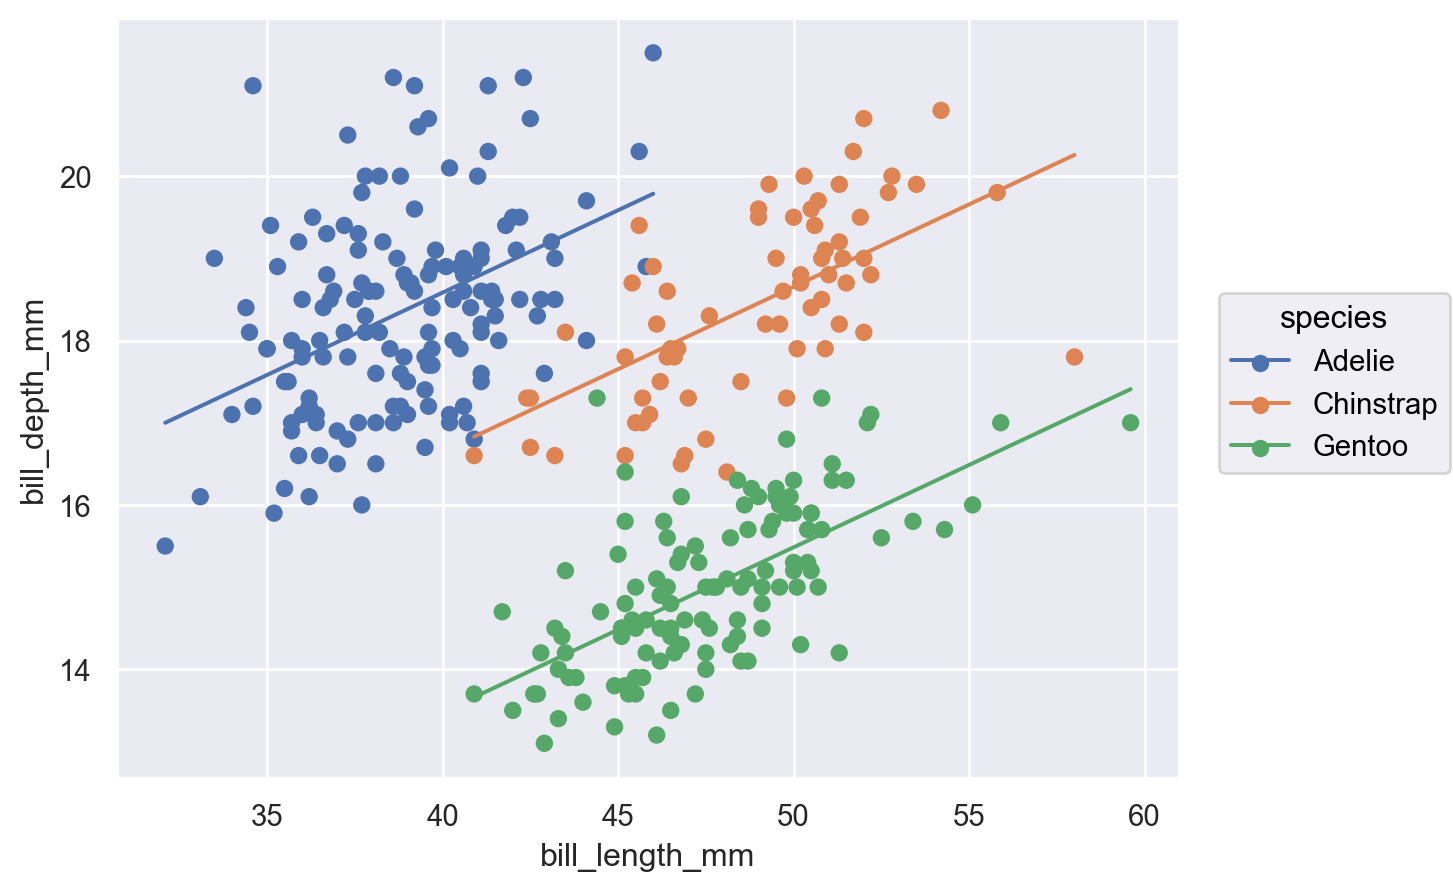

In [63]:
# Y si ponemos el color en el Plot?
(
    so.Plot(data = datos, x = "bill_length_mm", color = "species")
    .add(so.Dot(), y = "bill_depth_mm")
    .add(so.Line(), y = "predicciones") # Magia!
)

En el modelo anterior, utilizamos la misma pendiente para todas las rectas y distintos intecepts. ¿Por qué? ¿Cuáles son los intercepts para cada especie? ¿Cómo podemos elegir las columnas para que los intercepts sean más claros?

In [64]:
y, X = Formula("bill_depth_mm ~ bill_length_mm + species - 1").get_model_matrix(penguins)
X.head()

,bill_length_mm,species[Adelie],species[Chinstrap],species[Gentoo]
0,39.1,1,0,0
1,39.5,1,0,0
2,40.3,1,0,0
3,36.7,1,0,0
4,39.3,1,0,0


Coeficientes: [[ 0.20044313 10.56526162  8.63218372  5.46194629]]


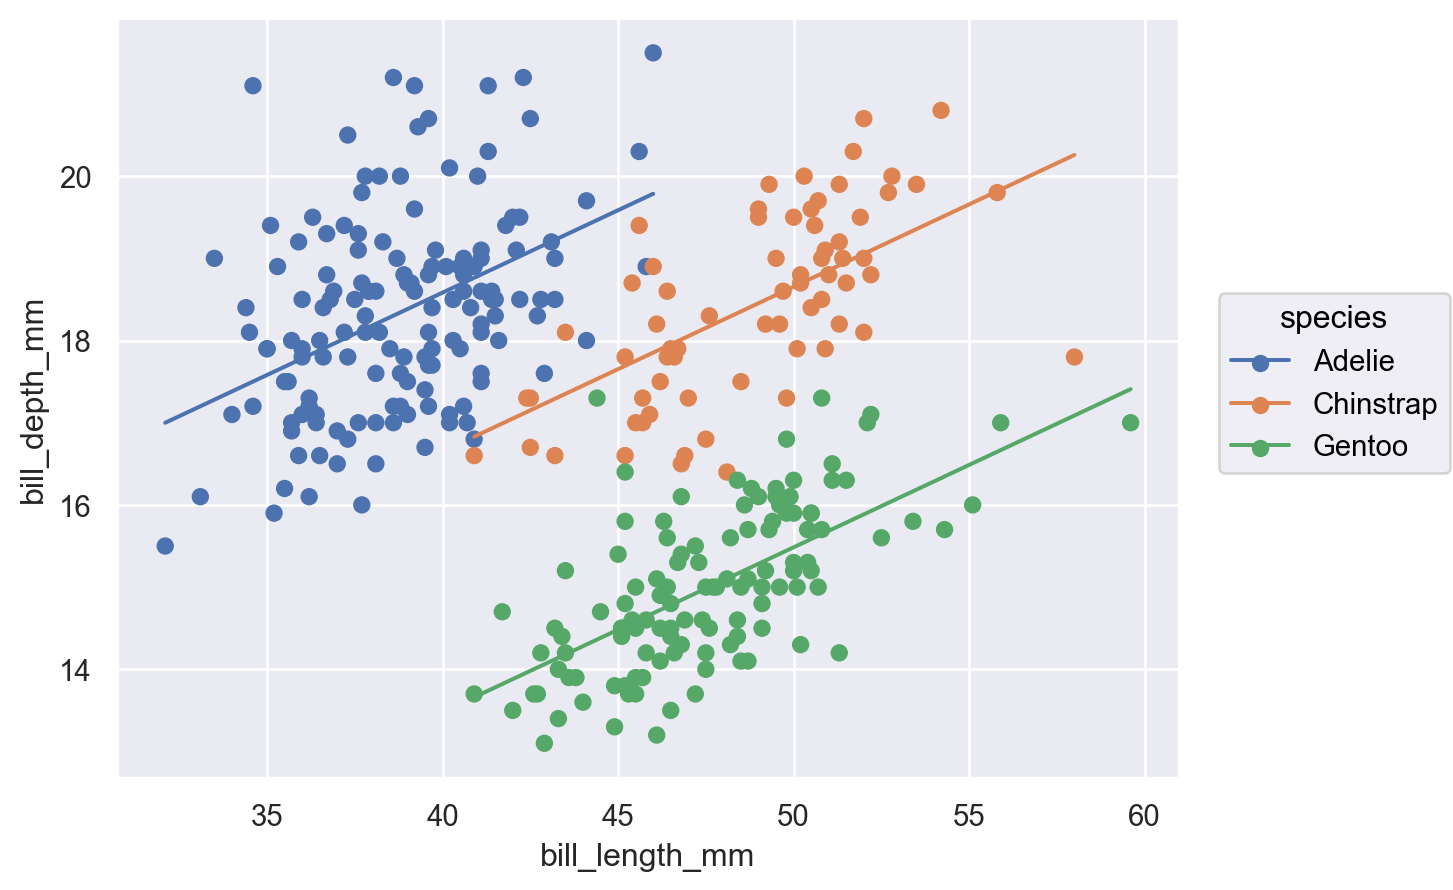

In [65]:
# Ajustamos el modelo 
modelo = linear_model.LinearRegression(fit_intercept = False)    # Inicializamos un modelo de Regresion Lineal sin intercept
modelo.fit(X, y)   # Realiza
print("Coeficientes:", modelo.coef_)

# Predecimos
y_pred = modelo.predict(X)
datos["predicciones"] = y_pred

# Graficamos
(
    so.Plot(data = datos, x = "bill_length_mm", color = "species")
    .add(so.Dot(), y = "bill_depth_mm")
    .add(so.Line(), y = "predicciones") # Milagro!
)

Obtenemos tres rectas paralelas (igual que antes). 

¿Cómo podemos modelar con 3 rectas distintas, una para cada especie?

In [66]:
# Agregamos las interacciones!
y, X = Formula("bill_depth_mm ~ bill_length_mm * species").get_model_matrix(penguins)
X.head()

,Intercept,bill_length_mm,species[T.Chinstrap],species[T.Gentoo],bill_length_mm:species[T.Chinstrap],bill_length_mm:species[T.Gentoo]
0,1.0,39.1,0,0,0.0,0.0
1,1.0,39.5,0,0,0.0,0.0
2,1.0,40.3,0,0,0.0,0.0
3,1.0,36.7,0,0,0.0,0.0
4,1.0,39.3,0,0,0.0,0.0


Tenemos 6 variables. Qué representa cada una?

In [67]:
modelo = linear_model.LinearRegression(fit_intercept = False)    # Inicializamos un modelo de Regresion Lineal sin intercept
modelo.fit(X, y)   # Realiza
print("Coeficientes:", modelo.coef_)

Coeficientes: [[11.48770713  0.17668344 -3.91856701 -6.36675118  0.04552828  0.03092816]]


¿Cuál es la ecuación que modela bill_depth para la especie Chinstrap? ¿Y para Adele?

In [68]:
# Cómo hacemos para tener los coeficientes separados para cada especie?

# Qué esperamos con esta fórmula?
y, X = Formula("bill_depth_mm ~ bill_length_mm * species - 1").get_model_matrix(penguins)
X.head()

,bill_length_mm,species[Adelie],species[Chinstrap],species[Gentoo],bill_length_mm:species[T.Chinstrap],bill_length_mm:species[T.Gentoo]
0,39.1,1,0,0,0.0,0.0
1,39.5,1,0,0,0.0,0.0
2,40.3,1,0,0,0.0,0.0
3,36.7,1,0,0,0.0,0.0
4,39.3,1,0,0,0.0,0.0


In [69]:
# Y ahora?
y, X = Formula("bill_depth_mm ~ bill_length_mm * species - 1 - bill_length_mm").get_model_matrix(penguins)
X.head()

,species[Adelie],species[Chinstrap],species[Gentoo],bill_length_mm:species[Adelie],bill_length_mm:species[Chinstrap],bill_length_mm:species[Gentoo]
0,1,0,0,39.1,0.0,0.0
1,1,0,0,39.5,0.0,0.0
2,1,0,0,40.3,0.0,0.0
3,1,0,0,36.7,0.0,0.0
4,1,0,0,39.3,0.0,0.0


Esta es la que copio el profe en el pizarron, es la mas sencilla de todas (en cuanto a explicacion)

In [70]:
modelo = linear_model.LinearRegression(fit_intercept = False)    # Inicializamos un modelo de Regresion Lineal sin intercept
modelo.fit(X, y)   # Realiza
print("Coeficientes:", modelo.coef_)

Coeficientes: [[11.48770713  7.56914012  5.12095595  0.17668344  0.22221172  0.2076116 ]]


**Pregunta:** ¿Cuáles coeficientes nos indican las pendientes de las rectas?

In [71]:
# Calculamos el R^2
y_pred = modelo.predict(X)

# Calculando el R^2
r2 = r2_score(y, y_pred)
print('R^2: ', r2)

R^2:  0.7680522348509106


Claro, ahora el R² nos da recontra alto, en lugar de 0.05, ya que estamos modelando con 6 variables, y no con 2!

In [74]:
# Los últimos tres números son las pendientes de las rectas.
# Cómo podemos graficar este modelo?

y_pred = modelo.predict(X)

datos = penguins.copy()
datos["predicciones"] = y_pred
datos.head()


,index,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,predicciones
0,0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male,18.396030
1,1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female,18.466703
2,2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female,18.608050
3,4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female,17.971989
4,5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male,18.431366


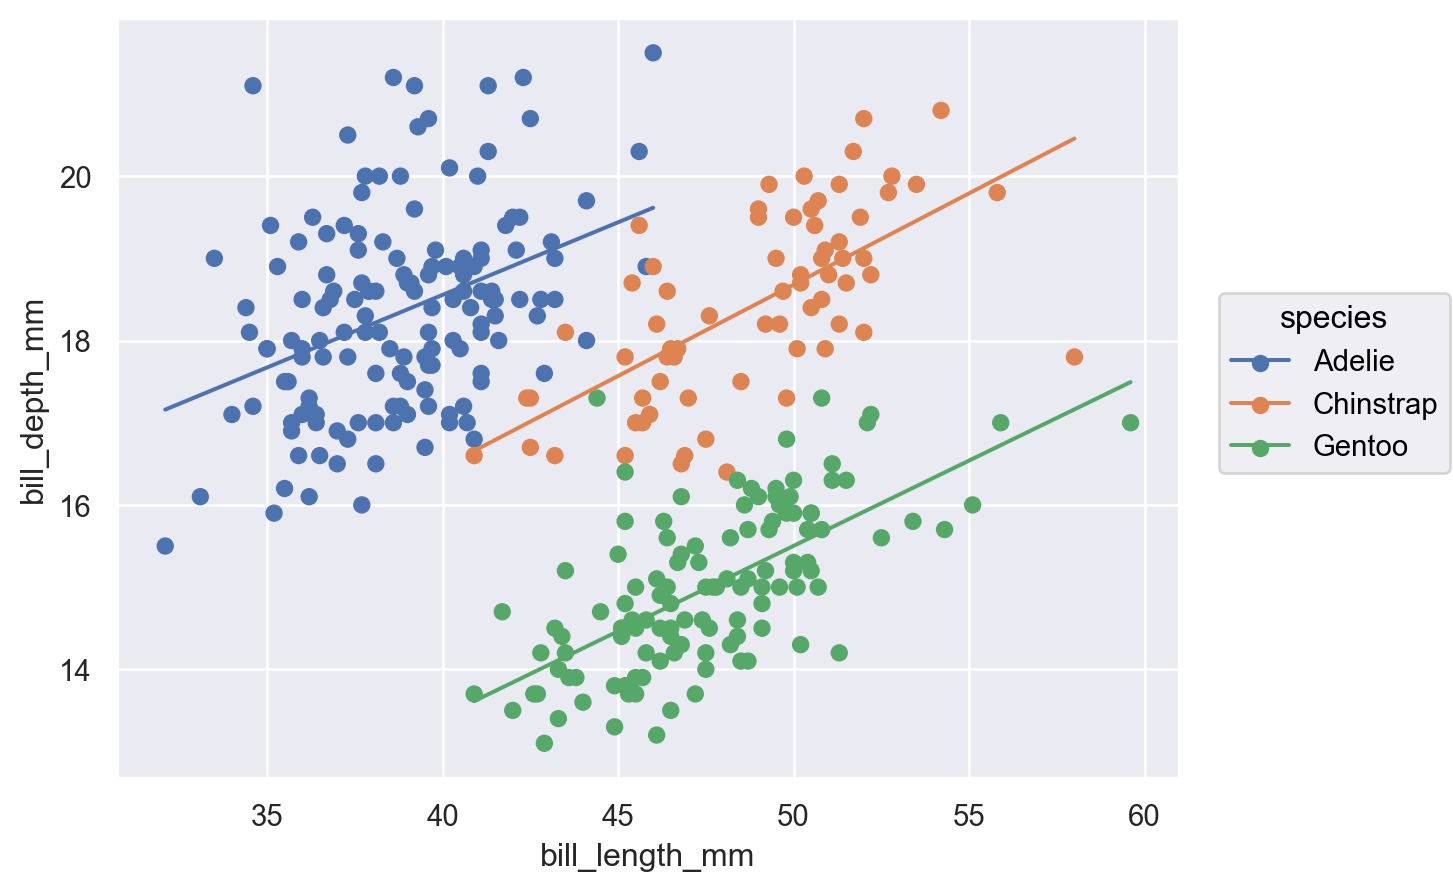

In [ ]:
(
    so.Plot(data = datos, x = "bill_length_mm", color = "species")
    .add(so.Dot(), y = "bill_depth_mm")
    .add(so.Line(), y = "predicciones")  # Magia!!
)

Notar que es exactamente el mismo grafico! Pero esta vez hicimos el modelo nosotros mismos!

## Repaso

Según la AI de Google:

Los **machos de jirafa** son, en promedio, más altos que las **hembras**.  
Los machos suelen alcanzar una altura de **5 metros**, mientras que las hembras suelen medir alrededor de **4 metros**.  
Se han registrado ejemplares de jirafa machos con una altura de hasta **6 metros**.

**En detalle:**

- **Machos:** Miden entre **4,8 y 5,5 metros** de altura, con algunos ejemplares que pueden superar los 5 metros.  
- **Hembras:** Alcanzan una altura de **4,3 a 4,8 metros**.  
- **Diferencia:** La diferencia en altura entre machos y hembras se debe a factores como el tamaño y el desarrollo óseo, que se ven afectados por la **edad** y el **sexo**.

Si queremos ajustar la altura de las jirafas utilizando la edad y el sexo, qué fórmula plantearíamos?